# Dataset: Facebook data
### https://www.kaggle.com/datasets/sheenabatra/facebook-data/data

## Импорт необходимых библиотек

In [268]:
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kstest, anderson, normaltest, ks_2samp, chi2_contingency
from itertools import combinations #декартово произведение без повторов
from random import randint

In [2]:
alpha = 0.05

In [205]:
df = pd.read_csv(r'C:\Users\mvideo\Desktop\pseudo_facebook.csv', index_col = 'userid')
df

,age,dob_day,dob_year,dob_month,gender,tenure,friend_count,friendships_initiated,likes,likes_received,mobile_likes,mobile_likes_received,www_likes,www_likes_received
userid,,,,,,,,,,,,,,
2094382,14,19,1999,11,male,266.0,0,0,0,0,0,0,0,0
1192601,14,2,1999,11,female,6.0,0,0,0,0,0,0,0,0
2083884,14,16,1999,11,male,13.0,0,0,0,0,0,0,0,0
1203168,14,25,1999,12,female,93.0,0,0,0,0,0,0,0,0
1733186,14,4,1999,12,male,82.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268299,68,4,1945,4,female,541.0,2118,341,3996,18089,3505,11887,491,6202
1256153,18,12,1995,3,female,21.0,1968,1720,4401,13412,4399,10592,2,2820
1195943,15,10,1998,5,female,111.0,2002,1524,11959,12554,11959,11462,0,1092


## Редактирование базы данных
#### В дальнейшем будет разбиение на 2 группы с диапазоном 15 лет. Взяты группы пользователей возраста меньше 50 лет, для относительно небольшого внутригруппового разрыва в поколениях и активности пользователей в социальной сети.

In [206]:
df = df[df.age < 50]

#### Так как пользователи, входящие в группы предполагаются активными, то будем считать, что у них есть хотя бы одно взаимодействие с их друзьями

In [207]:
df = df[df.friendships_initiated >= 1]

#### Удаление нерассматриваемых столбцов

In [208]:
df.drop(['mobile_likes', 'mobile_likes_received', 'www_likes', 'www_likes_received'], axis=1, inplace=True)

## Введем 3 метрики:
#### 1) Количество лайков поставленных за день (likes_pday)
#### 2) Количество друзей (friend_count)
#### 3) Количество полученных лайков в день (received_likes_pday)
#### Также были введены ограничения на некоторые показатели для усиления предпосылки об активности пользователей

In [209]:
df = df[(df.friend_count >= 5) &
(df.friend_count <= df.friend_count.mean() + 3 * df.friend_count.std()) &
(df.likes >= 25) &
(df.likes <= df.likes.mean() + 3 * df.likes.std()) & 
(df.likes_received <= df.likes_received.mean() + 3 * df.likes_received.std()) &
(df.tenure <= df.tenure.mean() + 3 * df.tenure.std()) & 
(df.tenure >= 30) &
(df.likes_received <= df.likes_received.mean() + 3 * df.likes_received.std()) & 
(df.likes_received >= 30)]

#### Создание столбца: Количество поставленных лайков в день

In [210]:
df['likes_pday'] = df['likes']/df['tenure']

#### Создание столбца: Количество полученных лайков в день

In [211]:
df['likes_received_pday'] = df['likes_received']/df['tenure']

## Введем 4 группы:
#### 1) Девушки от 20 до 35 лет

In [212]:
df_f_18 = df[(df.age < 35) & (df.age >= 20) & (df.gender == 'female')] 
df_f_18.shape

(4986, 12)

#### 2) Девушки от 35 до 50 лет

In [213]:
df_f_35 = df[(df.age >= 35) & (df.gender == 'female')] 
df_f_35.shape

(2110, 12)

#### 3) Мужчины от 20 до 35 лет

In [214]:
df_m_18 = df[(df.age < 35) & (df.age >= 20) & (df.gender == 'male')] 
df_m_18.shape

(3515, 12)

#### 4) Мужчины от 35 до 50 лет

In [215]:
df_m_35 = df[(df.age >= 35) & (df.gender == 'male')]
df_m_35.shape

(1127, 12)

#### Резюмируя списками

In [224]:
sectors = [df_m_18, df_f_18, df_m_35, df_f_35]
metrics = ['likes_pday', 'friend_count', 'likes_received_pday' ]
metrics_d = {'likes_pday': 'Количество поставленных лайков в день', 'friend_count': 'Количество друзей', 'likes_received_pday': 'Количество полученных лайков в день'}

#### Для ускорения процесса сделаем словари из имен

In [25]:
sectors = {'M20': df_m_18, 'F20': df_f_18, 'M35': df_m_35, 'F35': df_f_35}
sectors_nd = {'M20': 'Мужчины от 20 до 35 лет', 'F20': 'Женщины от 20 до 35 лет', 'M35': 'Мужчины от 35 до 50 лет',
              'F35': 'Женщины от 35 до 50 лет'}
comb_sect = list(combinations(sectors, 2)) #Декартово произведение из секторов без перестановок

# Задание №1 - №2

### Возьмем две метрики: 
### 1) Количество друзей 
### 2) Среднее количество лайков в день, сделанных пользователем

#### Первая метрика имеет дискретное распределение, т.к. может пробегать только натуральные числа
#### Вторая метрика имеет непрерывное распределение, т.к. средние значение могут пробегать любые значения

## Совпадение функций распределений двух выборок

### Во всех пунктах нулевая гипотеза: выборки взяты из одного распределения, альтернативная гипотеза: выборки взяты из разных распределений

#### 1) Критерий Пирсона, т.к. распределение выборки является дискретным

C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


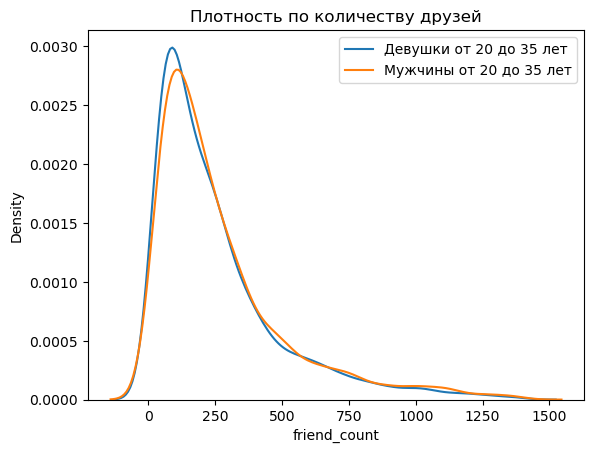

In [359]:
sns.kdeplot(df_f_18['friend_count'], label='Девушки от 20 до 35 лет').set_title('Плотность по количеству друзей')
sns.kdeplot(df_m_18['friend_count'], label='Мужчины от 20 до 35 лет').set_title('Плотность по количеству друзей')
plt.legend()

C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


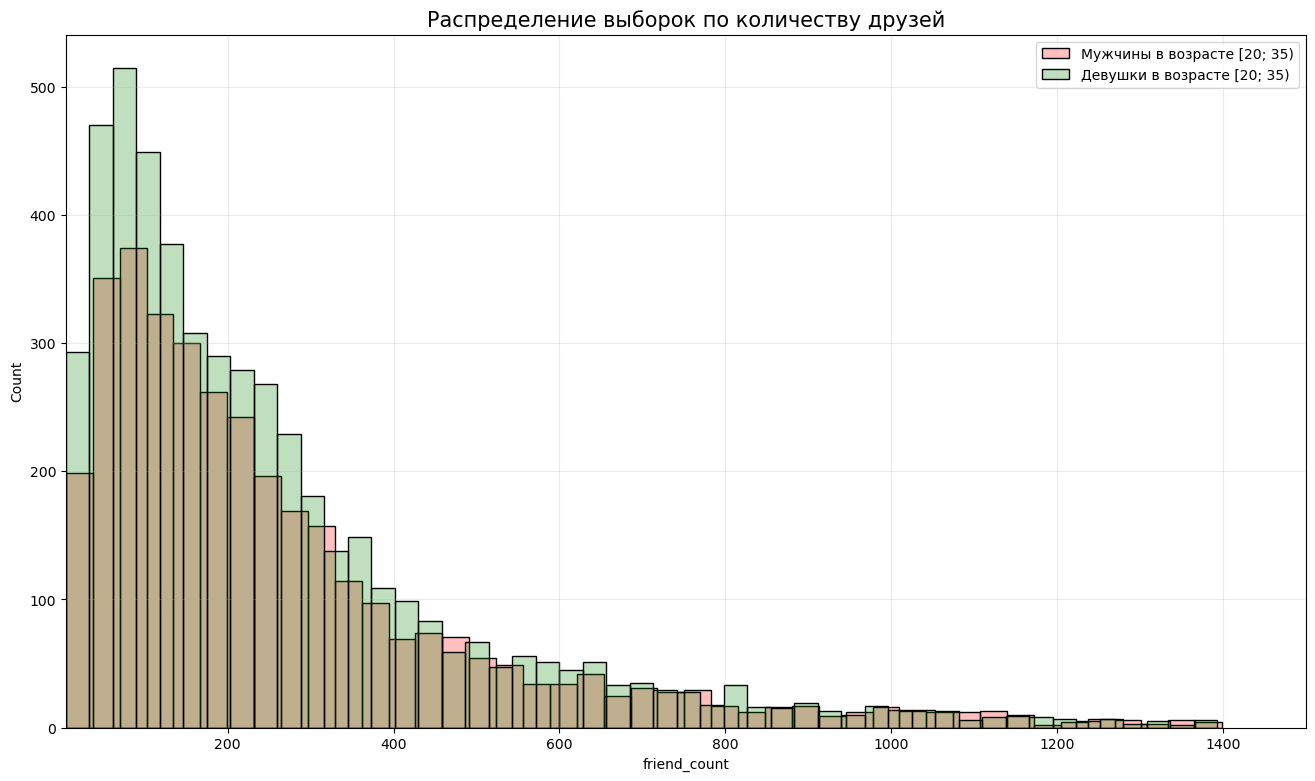

In [352]:
plt.figure(figsize=(16, 9))
plt.grid(alpha=0.25)

ax = sns.histplot(df_m_18['friend_count'], color='red', alpha=0.25, label='Мужчины в возрасте [20; 35)')
sns.histplot(df_f_18['friend_count'], color='green', alpha=0.25, ax=ax, label='Девушки в возрасте [20; 35)')
_ = ax.set_title('Распределение выборок по количеству друзей', size=15)
_ = ax.set_xlim(5, 1500)
ax.legend()

In [346]:
df_f_18_fct = list(df_f_18['friend_count'])

while len(df_f_18_fct) > len(df_m_18['friend_count']): # Для критерия Пирсона необходим одинаковый размер выборки
    i = randint(0, len(df_f_18_fct) - 1)               # Для этого выкинем случайны элементы (излишек) и одной выборки до количесва другой
    del df_f_18_fct[i]
    
chi2_contingency([df_f_18_fct, df_m_18['friend_count']])

Chi2ContingencyResult(statistic=2281.6693834477765, pvalue=1.0, dof=3514, expected_freq=array([[   4.8707902 ,    4.8707902 ,    4.8707902 , ..., 1309.75548444,
        1281.9919803 , 1267.86668873],
       [   5.1292098 ,    5.1292098 ,    5.1292098 , ..., 1379.24451556,
        1350.0080197 , 1335.13331127]]))

#### Гипотеза H0: выборки взяты из одинаковых распределений, НЕ ОТВЕРГАЕТСЯ, поскольку p-value больше любого разумного уровня значимости

#### 2) Тест Манна Уитни, т.к. хотим сохранить информацию о выброрке (не рассматриваем критерий знаков) и т.к. тест Колмогорова Смирнова не дает установить предположения, что одна функция распределения практически всегда может давать большие значение, чем другая функция распределения, но форма распределений в среднем одинаковая

C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


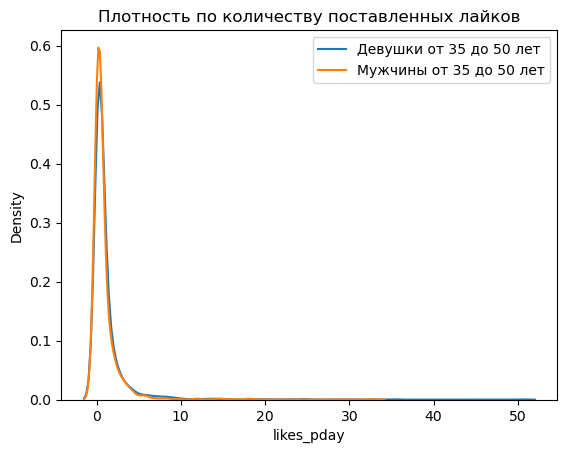

In [360]:
sns.kdeplot(df_f_35['likes_pday'], label='Девушки от 35 до 50 лет').set_title('Плотность по количеству поставленных лайков')
sns.kdeplot(df_m_35['likes_pday'], label='Мужчины от 35 до 50 лет').set_title('Плотность по количеству поставленных лайков')
plt.legend()

C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mvideo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


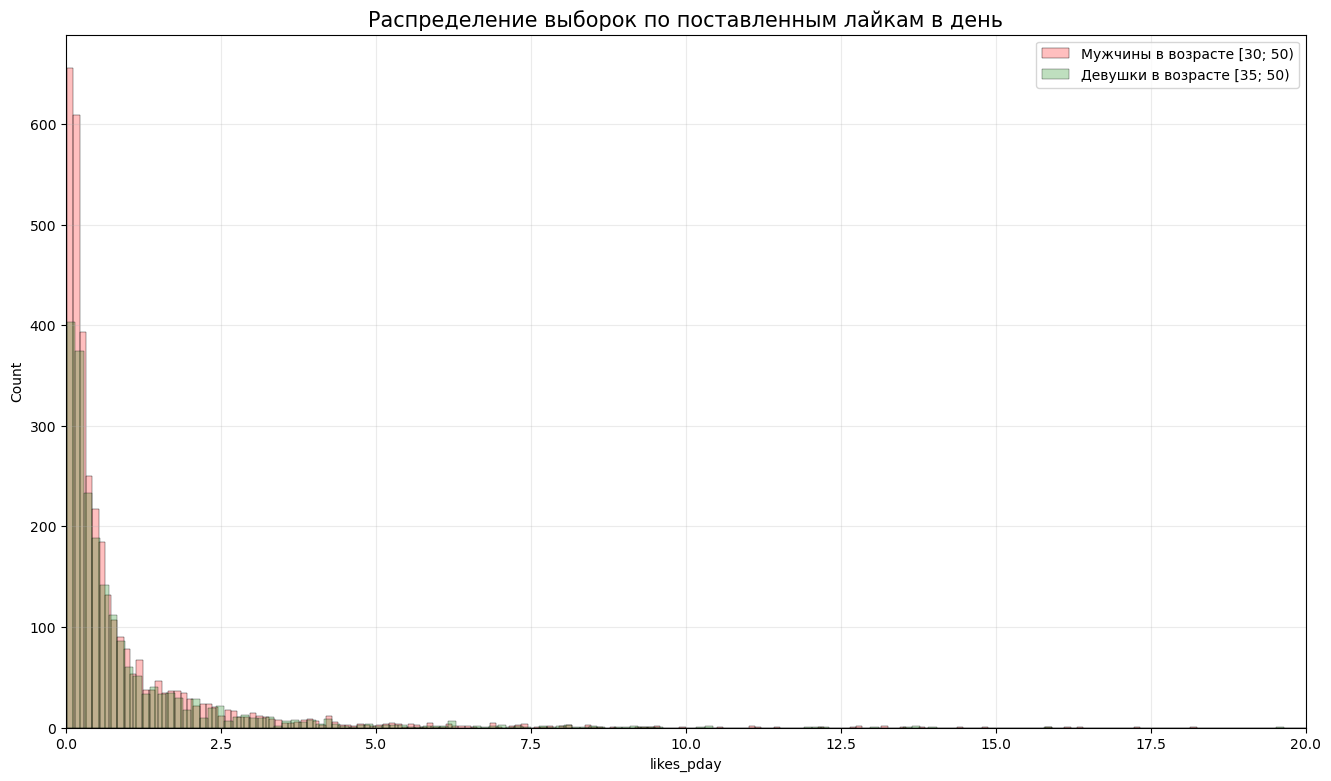

In [241]:
plt.figure(figsize=(16, 9))
plt.grid(alpha=0.25)

ax = sns.histplot(df_m_18['likes_pday'], color='red', alpha=0.25, label='Мужчины в возрасте [30; 50)')
sns.histplot(df_f_35['likes_pday'], color='green', alpha=0.25, ax=ax, label='Девушки в возрасте [35; 50)')
_ = ax.set_title('Распределение выборок по поставленным лайкам в день', size=15)
_ = ax.set_xlim(0, 20)
ax.legend()

In [242]:
print('P-value:', sts.mannwhitneyu(df_m_35['likes_pday'], df_f_35['likes_pday'], alternative='greater').pvalue)

P-value: 0.9999999866390651


#### Гипотеза H0: выборки взяты из одинаковых распределений, НЕ ОТВЕРГАЕТСЯ, поскольку p-value больше любого разумного уровня значимости

## Совпадение медиан
### Нулевая гипотеза: медиана разности двух выборок равны нулю, альтернативная гипотеза: не равна

#### 1)Дискретная выборка, количество друзей пользователей разного пола, но одной возрастной группы связаны одним поколоением

#### Т.к. распределение выборок дискретные и они связаны возьмем критерий знаков

In [435]:
_, pvalue = sign_test(np.array(df_m_18['friend_count']) - np.array(df_f_18_fct))
print(pvalue)

0.0


#### Гипотеза H0: медиана разности двух выборок равна нулю, НЕ ПРИНИМАЕТСЯ, поскольку p-value меньше любого разумного уровня значимости

#### 2) Возьмем количество полученных и поставленных лайков в день для девушек возраста [20; 35). Предполагается, что выборки связаны: пользователь ставит лайк другу, а он в свою очередь ставит лайк пользователю

#### Т.к. выборки связаны и распределение непрерывное возьмем ранговый тест Уилкоксона

In [438]:
print('P-value:', sts.wilcoxon(df_f_18['likes_pday'], df_f_18['likes_received_pday']).pvalue)

P-value: 1.4333484712713983e-11


#### Гипотеза H0: медиана разности двух выборок равна нулю, НЕ ПРИНИМАЕТСЯ, поскольку p-value меньше любого разумного уровня значимости

In [414]:
deltas = []
def efr_interv(a, b):
    ct1 = a.shape[0]
    ct2 = b.shape[0]
    
    for _ in range(1000):
        a_new = np.random.choice(a, size=ct1, replace=True)
        b_new = np.random.choice(b, size=ct2, replace=True)
        delta = np.median(b_new) - np.median(a_new)
        deltas.append(delta)
        
    interv = np.percentile(deltas, q=[alpha / 2 * 100, (1 - alpha / 2) * 100])
    left = interv[0]
    right = interv[1]
    
    print(f'Доверительный интервал: [{left:.3f}, {right:.3f}]. Ширина интервала: {right - left:.3f}')
    if left > 0:
        print()
        print('! ! ! Интервал лежит правее нуля, значит у выборок присутсвует статистически значимые различия')

In [417]:
efr_interv(df_m_18['friend_count'], pd.Series(df_f_18_fct))

Доверительный интервал: [-14.000, 8.000]. Ширина интервала: 22.000


In [418]:
efr_interv(df_f_18['likes_pday'], df_f_18['likes_received_pday'])

Доверительный интервал: [-14.000, 7.000]. Ширина интервала: 21.000


#### Во всех интервалах присутсвует значение ноль, значит возможен случай равенства медиан из двух выборок

## Задание №3

#### Поскольку в основе бутстрапа лежит семплирование большого количества выборок, то можно сказать, что этот подход по большей мере асимптотический. Учитывая, что результаты прошлых тестов давали значительно малые P-value, то делаем вывод, что бутстрап, в данном случае, менее мощный, чем вышеописанные тесты 